In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preparation

In [ ]:
# create dataframes from CSV's
cases = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative_Cases.csv')
vac = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Vaccinations.csv')
death = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Deaths.csv')
hosp = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Hospitalizations.csv')

In [ ]:
# combine into one dataframe
data = hosp.join(cases.set_index('Date'), on='Date').join(vac.set_index('Date'), on='Date').join(death.set_index('Date'), on='Date')

In [ ]:
data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths
0,2/25/2020,1092,0,1,NaN,2
1,2/26/2020,1094,0,1,NaN,4
2,2/27/2020,1105,0,1,NaN,4
3,2/28/2020,1114,0,1,NaN,6
4,2/29/2020,1121,0,1,NaN,7
5,3/1/2020,1129,0,1,NaN,10
6,3/2/2020,1150,13,14,NaN,13
7,3/3/2020,1162,16,30,NaN,16
8,3/4/2020,1176,15,45,NaN,18
9,3/5/2020,1203,21,66,NaN,23


In [ ]:
# create columns for daily counts, cases already has one
data['new_hosp'] = data['Hospitalizations'].diff()
data['new_vac'] = data['Vaccines'].diff()
data['new_deaths'] = data['Deaths'].diff()

In [ ]:
# add a time column
data['Time'] = np.arange(len(data.index))

In [ ]:
# check NA values do to nature of data can set NA values to 0
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                703 non-null    object 
 1   Hospitalizations    703 non-null    int64  
 2   New Cases Reported  703 non-null    int64  
 3   Cases               703 non-null    int64  
 4   Vaccines            407 non-null    float64
 5   Deaths              703 non-null    int64  
 6   new_hosp            702 non-null    float64
 7   new_vac             406 non-null    float64
 8   new_deaths          702 non-null    float64
 9   Time                703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [ ]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                703 non-null    object 
 1   Hospitalizations    703 non-null    int64  
 2   New Cases Reported  703 non-null    int64  
 3   Cases               703 non-null    int64  
 4   Vaccines            703 non-null    float64
 5   Deaths              703 non-null    int64  
 6   new_hosp            703 non-null    float64
 7   new_vac             703 non-null    float64
 8   new_deaths          703 non-null    float64
 9   Time                703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [ ]:
data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,new_hosp,new_vac,new_deaths,Time
0,2/25/2020,1092,0,1,0.0,2,0.0,0.0,0.0,0
1,2/26/2020,1094,0,1,0.0,4,2.0,0.0,2.0,1
2,2/27/2020,1105,0,1,0.0,4,11.0,0.0,0.0,2
3,2/28/2020,1114,0,1,0.0,6,9.0,0.0,2.0,3
4,2/29/2020,1121,0,1,0.0,7,7.0,0.0,1.0,4
5,3/1/2020,1129,0,1,0.0,10,8.0,0.0,3.0,5
6,3/2/2020,1150,13,14,0.0,13,21.0,0.0,3.0,6
7,3/3/2020,1162,16,30,0.0,16,12.0,0.0,3.0,7
8,3/4/2020,1176,15,45,0.0,18,14.0,0.0,2.0,8
9,3/5/2020,1203,21,66,0.0,23,27.0,0.0,5.0,9


# Data Exploration

In [ ]:
data.describe()

,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,new_hosp,new_vac,new_deaths,Time
count,703.000000,703.000000,7.030000e+02,7.030000e+02,703.000000,703.000000,703.000000,703.000000,703.000000
mean,20034.984353,1841.389758,3.348000e+05,3.939406e+06,4523.671408,73.863442,17954.691323,15.216216,351.000000
std,14123.885448,3257.851156,2.900508e+05,4.450399e+06,3055.390423,57.055515,22558.748645,10.666075,203.082906
min,1092.000000,0.000000,1.000000e+00,0.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000
25%,7429.500000,470.500000,6.905400e+04,0.000000e+00,1809.500000,34.000000,0.000000,7.000000,175.500000
50%,19244.000000,912.000000,3.250510e+05,1.075985e+06,4807.000000,54.000000,9899.000000,12.000000,351.000000
75%,28215.500000,1981.000000,4.867350e+05,8.280368e+06,6250.500000,99.000000,30096.000000,21.000000,526.500000
max,53018.000000,39227.000000,1.294498e+06,1.262217e+07,10699.000000,339.000000,92611.000000,53.000000,702.000000


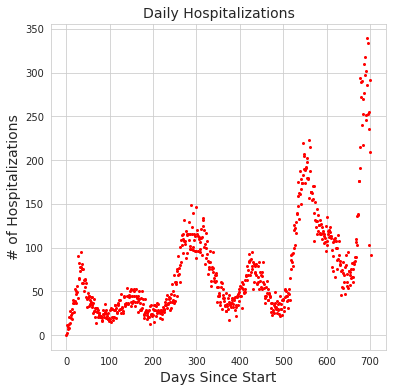

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_hosp'], color='red', s = 4)
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

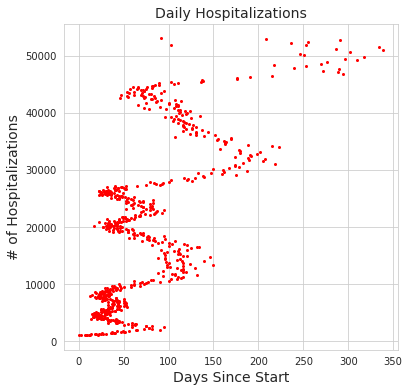

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['new_hosp'], data['Hospitalizations'], color='red', s = 4)
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

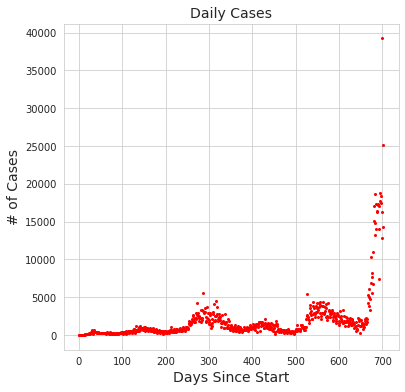

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['New Cases Reported'], color='red', s= 4)
plt.title('Daily Cases', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Cases', fontsize=14)
plt.grid(True)
plt.show()

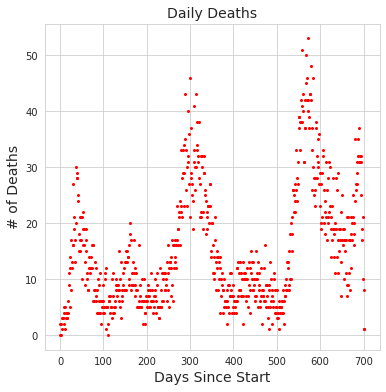

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_deaths'], color='red', s = 4)
plt.title('Daily Deaths', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Deaths', fontsize=14)
plt.grid(True)
plt.show()

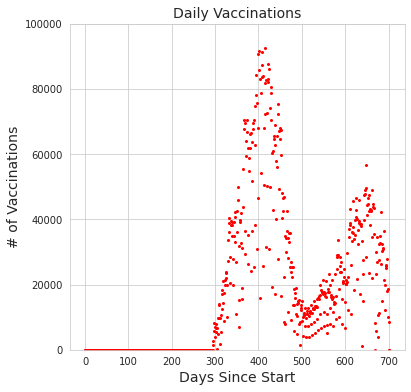

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data['Time'], data['new_vac'], color='red', s = 4)
plt.title('Daily Vaccinations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Vaccinations', fontsize=14)
plt.grid(True)
plt.ylim(0,100000)
plt.show()

# Linear Regression

To estimate the initial covariance

In [ ]:
X = data[['new_hosp']]
Y = data[['Hospitalizations']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [8244.87443514]
Coefficients: 
 [[159.07261251]]


In [ ]:
reg.score(x_train,y_train)

0.4295770614590769

In [ ]:
reg.score(x_test,y_test)

0.38840852465096243

In [ ]:
np.cov(data['new_hosp'], data['Hospitalizations'])

array([[3.25533175e+03, 5.23620613e+05],
       [5.23620613e+05, 1.99484140e+08]])

To estimate the obsveration noise std

In [ ]:
X = data[['Time']]
Y = data[['Hospitalizations']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [-3837.84767031]
Coefficients: 
 [[67.95391667]]


In [ ]:
prediction = reg.predict(x_test)
residual1 = (y_test - prediction)

In [ ]:
np.std(residual)

new_hosp    45.772543
dtype: float64

In [ ]:
X = data[['Time']]
Y = data[['new_hosp']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [15.59129875]
Coefficients: 
 [[0.16440334]]


In [ ]:
prediction = reg.predict(x_test)
residual2 = (y_test - prediction)

In [ ]:
np.std(residual)

new_hosp    45.772543
dtype: float64

noises

In [ ]:
X = residual1
Y = residual2

In [ ]:
X = np.stack((X['Hospitalizations'].to_numpy(),Y['new_hosp'].to_numpy()),axis =0)

In [ ]:
np.cov(X)

array([[8.46003196e+06, 1.96156233e+03],
       [1.96156233e+03, 2.43097959e+03]])

# Multiple Linear Regression

In [ ]:
X = data[['New Cases Reported','new_deaths','new_vac','Time']]
Y = data[['new_hosp']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [3.02227115]
Coefficients: 
 [[ 8.95038241e-03  2.16530512e+00 -8.64689093e-05  6.68032978e-02]]


In [ ]:
reg.score(x_train,y_train)

0.8001807017585729

In [ ]:
reg.score(x_test,y_test)

0.8654683528024966

In [ ]:
y_predicted = reg.predict(x_test)
resid = y_test - y_predicted

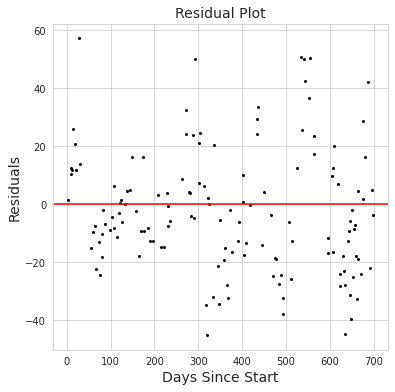

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], resid, color='black', s= 4)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True)
plt.show()

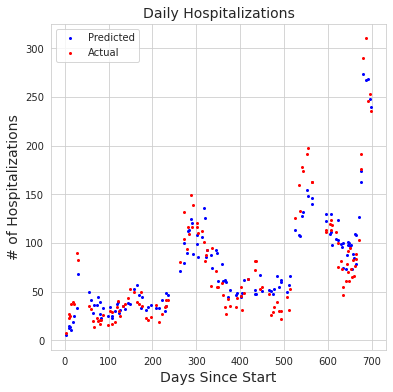

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], reg.predict(x_test), color='blue', s= 4)
plt.scatter(x_test['Time'], y_test['new_hosp'], color = 'red', s =4)
plt.legend(['Predicted','Actual'])
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

# Kalman Filter

In [ ]:
!pip install pykalman -q

In [ ]:
from pykalman import KalmanFilter

#### Time

In [ ]:
#Time step
dt = 1

#Number of time steps
n_timesteps = len(data['Time'])

#Time
t = np.arange(n_timesteps)*dt

#### Matrices

Define the matrices $A$, $B$, and $C$.

In [ ]:
A = np.array([[1, dt],
             [0, 1]])

B = np.array([[0],[0]])

C = np.array([[1, 0]])

#Use these matrices to determine the dimensions of the state and observation vectors
n_dim_state = A.shape[0]

n_dim_obs = C.shape[0]

#### Control Signal

We will not use a control signal in this application

Get an array of zeros with proper length

In [ ]:
u = np.ones((1,n_timesteps))

In [ ]:
b = np.matmul(B,u)

In [ ]:
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [ ]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[1000,0.0],[0.0,45]]

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [ ]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 2810

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the dynamics to simulate the system

Initialize the state vector and select an initial state.

In [ ]:
x = np.zeros((n_dim_state, n_timesteps))

x[:,0] = [1000.0, 60.0]
#stats.multivariate_normal.rvs([0.0, 0.0], np.identity(2))

In [ ]:
x

array([[1000.,    0.,    0., ...,    0.,    0.,    0.],
       [  60.,    0.,    0., ...,    0.,    0.,    0.]])

Run the state dynamics

In [ ]:
for n in range(n_timesteps - 1):
  x[:,n+1] = np.matmul(A,x[:,n]) + b[:,n] + state_noise.rvs()

In [ ]:
x

array([[ 1000.        ,  1029.25021974,  1033.51874113, ...,
        25747.04794865, 25765.60299951, 25818.5361766 ],
       [   60.        ,    63.42981738,    58.09639017, ...,
           50.17979732,    50.98195642,    43.54065375]])

Create the observations

In [ ]:
y = data['Hospitalizations']

#### Use the Kalman filter to estimate the states

Define a Kalman filter object with the known properties of the system

In [ ]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [ ]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

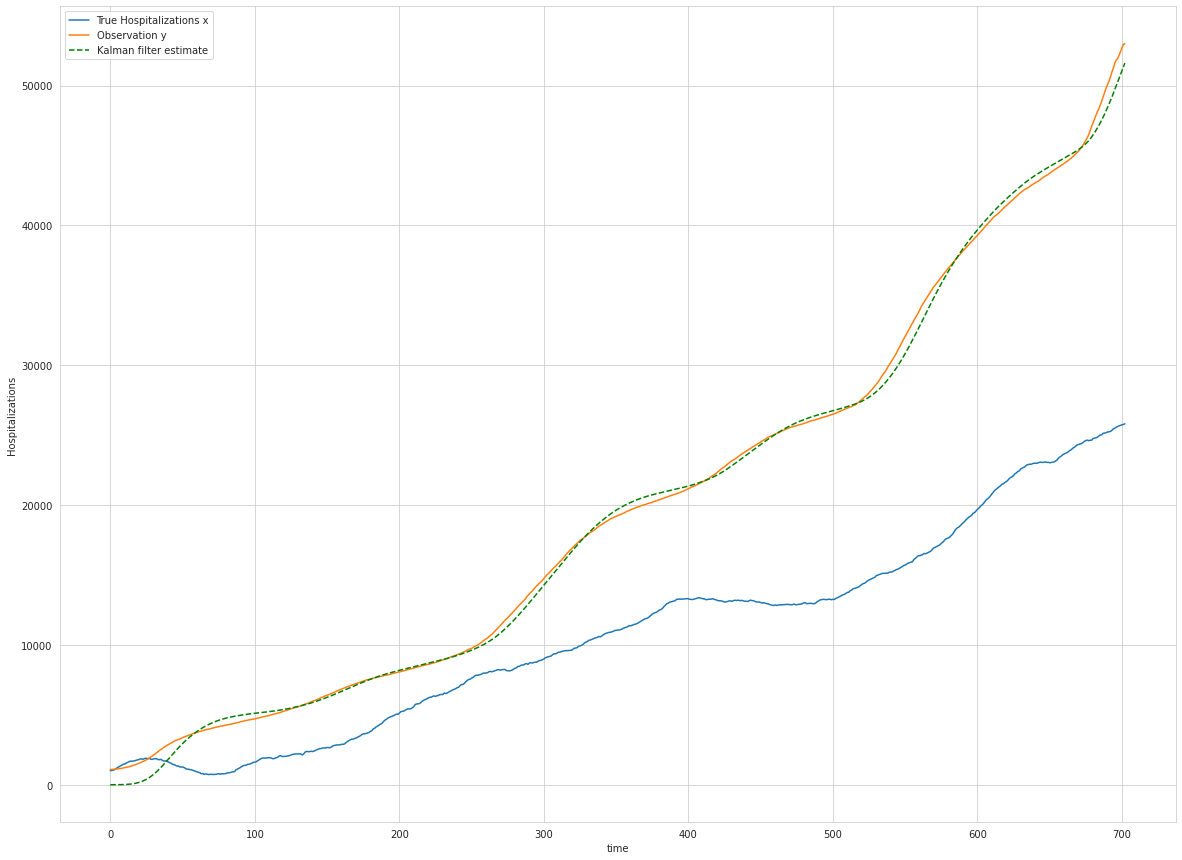

In [ ]:
#Plot position
plt.figure(figsize = (20,15))
plt.plot(t,x[0,:])
plt.plot(t,y)
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['True Hospitalizations x', 'Observation y', 'Kalman filter estimate'])


#### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [ ]:
state_cov_matrix_guess = [[2800,0.0],[0.0,45]]

obs_std_guess = 2810.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [ ]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [ ]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [ ]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[2252.05851764  102.60248999]
 [ 102.60248999   53.11561708]] . True covariance =  [[2252.05851764  102.60248999]
 [ 102.60248999   53.11561708]]


In [ ]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[3535.14422096]] . True variance =  [[3535.14422096]]


#### Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [ ]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

#Create the random variable 
state_noise = stats.multivariate_normal(state_mean_vec, state_cov_matrix)

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [ ]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

#Create the random variable 
obs_noise = stats.norm(loc = obs_mean, scale = obs_std)

#### Use the dynamics to simulate the system

Initialize the state vector and select a random initial state.

In [ ]:
x = np.zeros((n_dim_state, n_timesteps))

x[:,0] = x[:,0] = [1000.0, 60.0]

Run the state dynamics

In [ ]:
for n in range(n_timesteps - 1):
  x[:,n+1] = np.matmul(A,x[:,n]) + b[:,n] + state_noise.rvs()

Define a Kalman filter object with the known properties of the system

In [ ]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [ ]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter.

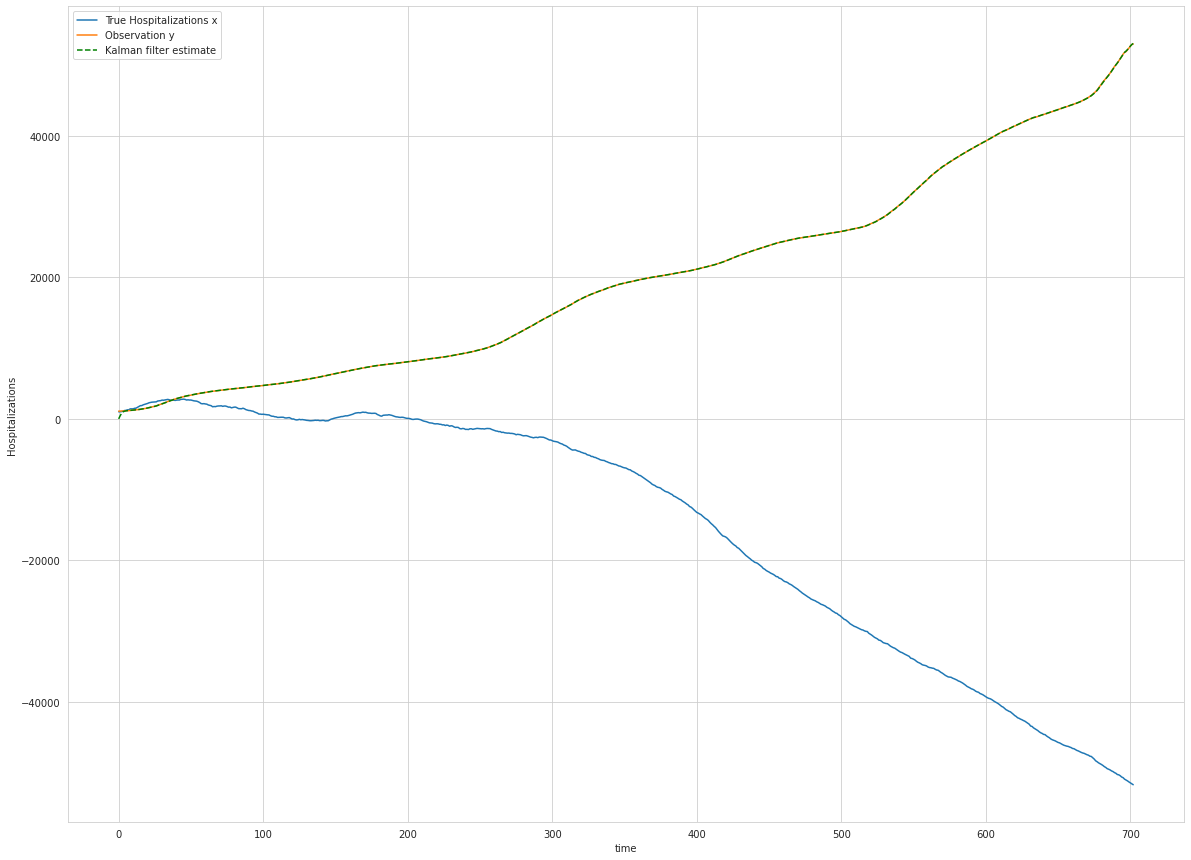

In [ ]:
#Plot position
plt.figure(figsize = (20,15))
plt.plot(t,x[0,:])
plt.plot(t,y)
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['True Hospitalizations x', 'Observation y', 'Kalman filter estimate'])
